# Model

Done by:
- Ana Farinha | 20211514
- Ana Reis | 20211631
- Beatriz Barreto | 20211547
- Mariana Neto | 20211527

### <font color='#e0218a'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [0. Import Libraries and Data](#P0)
    - [Import Necessary Libraries](#P0.1)
    - [Import Dataset](#P0.2)
- [1. Training the model](#P1)
    - [Grid Search](#P1.1)
    - [Stratified K-Fold](#P1.2)
        - [Results](#P1.2.1)
        - [Confusion Matrix](#P1.2.2)
        - [Classification Report](#P1.2.3)
- [2. Predictions for Kaggle](#P2) 
    - [Preprocessing](#P2.1)
- [3. Export Predictions](#P3) 

### <font color='#e0218a'>0. Import Libraries and Data</font> <a class="anchor" id="P0"></a>
  [Back to TOC](#toc)
  
In this step we will import the necessary libaries, our shortcuts with the functions we made and the dataset.

### Import necessary libraries and shortcuts <a class="anchor" id="P0.1"></a>

[Back to TOC](#toc)

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import seaborn as sns

# Model
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Progress Bar
from tqdm import tqdm
tqdm.pandas()

# Import preprocessing functions from shortcuts.py
import shortcuts

### Import dataset <a class="anchor" id="P0.2"></a>

[Back to TOC](#toc)

We will be using the dataset created during the preprocessing stage.

In [2]:
# Define the path and import the dataset
path = "./data_updated/"

In [3]:
train_data = pd.read_csv(path + "preprocesssed_data.csv")
train_data

,title,tag,artist,year,views,features,lyrics,preprocessed_lyrics,sa_lyrics
0,Walk Away,rock,Tony Molina,2013,699,{},When you said you loved me\nDid you mean it th...,said loved mean change mind day pretend walk a...,When you said you loved me Did you mean it the...
1,Gotta Make It Kid Naruto Rap,rap,Reece Lett,2021,4,{Sl!ck},Kid Naruto Rap\n\nEverybody wants you to hurt\...,kid naruto rap everybody wants hurt everybody ...,Kid Naruto Rap Everybody wants you to hurt Eve...
2,​this is what i asked for,pop,Elliot (DNK),2019,389,{},\nPeople tell me I've changed\nI find it hard ...,people tell changed find hard maybe feel make ...,People tell me I have changed I find it hard t...
3,Stealing Hearts,pop,Katie Armiger,2013,126,{},You've been warned about me\nDon't try to get ...,warned try get close want chain leave ghost to...,You have been warned about me Do not try to ge...
4,Get Ready,country,John Campbell Munro,1,2,{},\nI can see the end is coming but I've never l...,end coming never liked odds need way even deal...,I can see the end is coming but I have never l...
...,...,...,...,...,...,...,...,...,...
133238,Manhattan,pop,Tijuana Sweetheart,2007,48,{},If I knew when I was young that I'd be older\n...,knew young would older many things would told ...,If I knew when I was young that I would be old...
133239,Belly Shit,rap,Lil Gotit,2019,3593,"{""Lil Troup""}",\nCash\nWah-wah-wah\nWah-wah-wah\nEverything i...,cash wah wah wah wah wah wah everything chrome...,Cash Wah wah wah Wah wah wah Everything is chr...
133240,The Four Loves,rock,Heath McNease,2014,301,{},\nI was born inside a home\nThe youngest of th...,born inside home youngest three boys fought da...,I was born inside a home The youngest of the t...
133241,Ball And Chain,pop,Transmatic,2001,46,{},Rollin' by the pool the falling stars are not ...,rollin pool falling stars condescending twins ...,Rollin' by the pool the falling stars are not ...


### <font color='#e0218a'>1. Training the model</font> <a class="anchor" id="P1"></a>
  [Back to TOC](#toc)

This next step involves training our model. To do so, we started by trying different combinations of feature extraction and classification models. For feature extraction, we tried using Bag of Words, TF-IDF and word embeddings such as Word2Vec and Doc2Vec. As for classification models, we used Logistic Regression, MultinnomialNB, Decision Trees, Random Forests and neural networks. Below, is the grid search for the combination that resulted in the best f1-score.

### Grid Searh <a class="anchor" id="P1.1"></a>

[Back to TOC](#toc)

Here is the grid search using Doc2Vec as feature extraction and Logistic Regression as classification model.

In [4]:
# Grid search
'''
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(train_data['preprocessed_lyrics'], train_data['tag'], test_size=0.2, random_state=42)

# Tagging documents
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X_train)]

# Training Doc2Vec model
model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=4, epochs=20)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Generate vectors for training and testing sets
X_train_vectors = shortcuts.infer_vectors(model, X_train)
X_test_vectors = shortcuts.infer_vectors(model, X_test)


# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # regularization strength
    'penalty': ['l1', 'l2'],  # penalty type
    'solver': ['liblinear', 'saga']  # solver algorithm
}

# Initialize logistic regression model
logreg_model = LogisticRegression(max_iter=1000)

# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with F1 score as the scoring metric
grid_search = GridSearchCV(logreg_model, param_grid, cv, cv scoring='f1_weighted')

# Fit the grid search to the data
grid_search.fit(X_train_vectors, y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_
'''

'\nfrom gensim.models.doc2vec import Doc2Vec, TaggedDocument\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import StratifiedKFold\nfrom sklearn.model_selection import train_test_split\n\n# Train Test split\nX_train, X_test, y_train, y_test = train_test_split(train_data[\'preprocessed_lyrics\'], train_data[\'tag\'], test_size=0.2, random_state=42)\n\n# Tagging documents\ntagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X_train)]\n\n# Training Doc2Vec model\nmodel = Doc2Vec(vector_size=300, window=5, min_count=1, workers=4, epochs=20)\nmodel.build_vocab(tagged_data)\nmodel.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)\n\n# Generate vectors for training and testing sets\nX_train_vectors = shortcuts.infer_vectors(model, X_train)\nX_test_vectors = shortcuts.infer_vectors(model, X_test)\n\n\n# Define the parameter grid\nparam_grid = {\n   

Best parameters from the grid search above: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}

### Stratified K-Fold <a class="anchor" id="P1.2"></a>

[Back to TOC](#toc)

Below, we train our model using stratified k-fold and the best parameters given by our grid search.

In [5]:
# Data
X = train_data['preprocessed_lyrics']
y = train_data['tag']

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

overall_score_columns = ["accuracy","precision","recall","f1"]
overall_score_data = []
predictions_data = []

for train_index, val_index in skf.split(X, y):
    # Split train an validation data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Tagging documents
    tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(X_train)]

    # Initialize the Doc2Vec model
    model = Doc2Vec(vector_size=300, window=5, min_count=1, workers=4, epochs=10)

    # Training Doc2Vec model
    model.build_vocab(tagged_data)
    model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

    # Generate vectors for training and testing sets
    X_train_vectors = shortcuts.infer_vectors(model, X_train)
    X_val_vectors = shortcuts.infer_vectors(model, X_val)

    # Initialize and train the logistic regression model
    logreg_model = LogisticRegression(max_iter=1000, C =  10, penalty = 'l1', solver = 'saga')
    logreg_model.fit(X_train_vectors, y_train)

    # Predictions on the test set
    y_pred = logreg_model.predict(X_val_vectors)

    fold_score = list(shortcuts.fold_score_calculator(y_pred, y_val))
    overall_score_data.append(fold_score)
        
    # Store predictions and corresponding indices in a DataFrame
    fold_predictions = pd.DataFrame({
        'ValIndex': val_index,
        'Prediction': y_pred
        })
    predictions_data.append(fold_predictions)

scores_df = pd.DataFrame(overall_score_data, columns=overall_score_columns)
predictions_df = pd.concat(predictions_data, ignore_index=True)


#### Results <a class="anchor" id="P1.2.1"></a>

[Back to TOC](#toc)

Following, we have the scores given by our stratified k-fold. In our case, the data is imbanlanced so we are guiding ourselves by the f1-score.

In [6]:
scores_df

,accuracy,precision,recall,f1
0,0.646591,0.625073,0.646591,0.609897
1,0.647004,0.622927,0.647004,0.608942
2,0.647567,0.627804,0.647567,0.611585
3,0.645039,0.623869,0.645039,0.607315
4,0.644138,0.620321,0.644138,0.607666


Above, we can see that our f1-score is between 0.606 and 0.609 which means that our model's performance is stable when dealing with imbalanced data.

In [7]:
scores_df.mean()

accuracy     0.646068
precision    0.623999
recall       0.646068
f1           0.609081
dtype: float64

The average of the f1-score from all fold is 0.609.

#### Confusion Matrix<a class="anchor" id="P1.2.2"></a>

[Back to TOC](#toc)

Here, we have the confusion matrix for the last trained model.

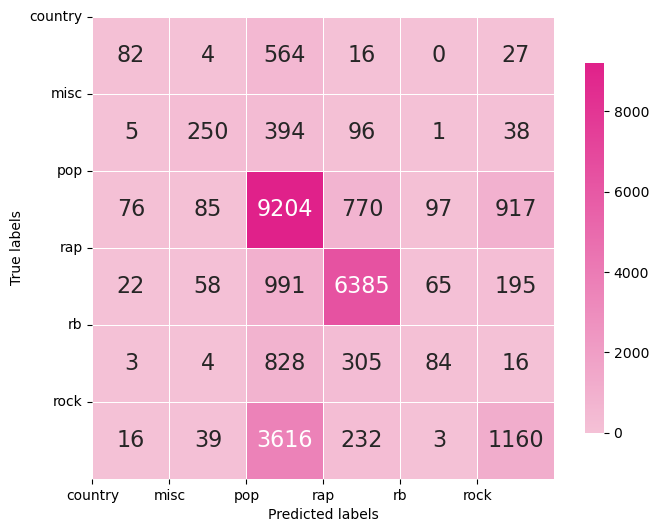

In [8]:
# Calculate a confusion matrix
cm = confusion_matrix(y_val, y_pred)
song_tags = np.unique(y_val)

# Define the colormap
colormap = sns.color_palette("blend:#f4c1d6,#e0218a", as_cmap=True)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap=colormap, linewidths=.5, square=True, cbar_kws={"shrink": 0.8}, annot_kws={"size": 16})

# Set axis labels using class names
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(ticks=range(len(song_tags)), labels=song_tags)
plt.yticks(ticks=range(len(song_tags)), labels=song_tags, rotation=0)

# Show the plot
plt.show()

In the confusion matrix above we can take the following conclusions:
 - Most of the 'rock' songs were wronfully predicted as 'pop'.
 - 'pop' and 'rap' were the genres were our prediction was more accurate.
 - Most of the wrongfully predicted 'tag' were predicted as 'pop'.

#### Classification Report <a class="anchor" id="P1.2.3"></a>

[Back to TOC](#toc)

Below, we have the classification report of the last model we trained.

In [9]:
# Classification report
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

     country       0.40      0.12      0.18       693
        misc       0.57      0.32      0.41       784
         pop       0.59      0.83      0.69     11149
         rap       0.82      0.83      0.82      7716
          rb       0.34      0.07      0.11      1240
        rock       0.49      0.23      0.31      5066

    accuracy                           0.64     26648
   macro avg       0.53      0.40      0.42     26648
weighted avg       0.62      0.64      0.61     26648



From the classification report, we take the following conclusions:
 - The f1-score is 0.61%.
 - The model performs relatively well on the 'pop' class with high precision, recall, and f1-score.
 - The 'rap' class also shows strong performance, with high precision, recall, and f1-score.
 - The 'rock' class has lower precision, recall, and F1-score, indicating that the model struggles more with this class.

### <font color='#e0218a'>2. Predictions for Kaggle</font> <a class="anchor" id="P2"></a>
  [Back to TOC](#toc)

  Below, we predict the 'tag' of the test data using our newly trained model.

### Preprocessing <a class="anchor" id="P2.1"></a>

[Back to TOC](#toc)

Our first step is to import the data and apply to it the same steps that the train data went through.

In [10]:
# True if data is already preprocessed
pre_proc_test = False

In [11]:
if pre_proc_test:
    test_df = pd.read_csv(path + "test_preproc.csv")
    # Set the 'id' column as the index
    test_df.set_index("id", inplace=True)
else:
    test_df = pd.read_csv(path + "test.csv")
    # Set the 'id' column as the index
    test_df.set_index("id", inplace=True)
    shortcuts.extract_and_remove_square_brackets(test_df, 'lyrics', False)
    # remove round brackets but not text within
    train_data['lyrics'] = train_data['lyrics'].map(lambda s: re.sub(r'\(|\)', '', s))
    train_data['lyrics'] = train_data['lyrics'].apply(lambda content: shortcuts.apostrophe_substitution(content))
    # Lowercase, remove ponctuation, remove stopwords, correct spelling, lemmatization, tokenization 
    test_df['preprocessed_lyrics'] = test_df['lyrics'].progress_apply(lambda content: shortcuts.preprocessor(content,
                                                                                                            lowercase=True, 
                                                                                                            leave_punctuation = False, 
                                                                                                            remove_stopwords = True,
                                                                                                            correct_spelling = False, 
                                                                                                            lemmatization=False, 
                                                                                                            tokenized_output=False, 
                                                                                                            sentence_output=False
                                                                                                            ))
    test_df.to_csv(path + 'test_preproc.csv',index=True)

100%|██████████| 33742/33742 [00:53<00:00, 635.45it/s]


In [12]:
# Generate vectors for the test set
X_test_vectors = shortcuts.infer_vectors(model, test_df['preprocessed_lyrics'])

### Predictions <a class="anchor" id="P2.2"></a>

[Back to TOC](#toc)

Below, we predict the 'tag' for our test data, associate with the respective 'id' and create a new dataframe for the Kaggle competition.

In [13]:
# Predictions on the test set
y_pred = logreg_model.predict(X_test_vectors)
test_index = list(test_df.index)

In [14]:
# Create a new dataframe with our predictions
submission_df = pd.DataFrame({'id': test_index, 'tag': y_pred})
submission_df

,id,tag
0,3996359,pop
1,3553166,rock
2,2998742,pop
3,3993470,rap
4,5488256,pop
...,...,...
33737,1149534,pop
33738,2473358,rap
33739,5254514,pop
33740,1646153,pop


### <font color='#e0218a'>3. Export our predictions</font> <a class="anchor" id="P3"></a>
  [Back to TOC](#toc)

  Our last step is to export our new dataframe to submit on Kaggle.

In [15]:
submission_df.to_csv('Group05__Versionxx.csv', index=False)